In [1]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5

## Dataprep

In [2]:
ts = pd.read_csv('weatherHistory.csv')

In [3]:
ts = ts[['Formatted Date','Temperature (C)','Humidity','Wind Speed (km/h)','Pressure (millibars)']]
ts = ts.rename(columns={"Temperature (C)": "Temperature","Formatted Date":"Date","Wind Speed (km/h)":"Wind speed", "Pressure (millibars)":"Pressure"})
# tsuv['Date'] = pd.to_datetime(tsuv['Date'])

In [4]:
ts['Date'] = ts['Date'].str[:10]
ts = ts.drop_duplicates('Date')
ts['Date'] = ts['Date'].str[:7]
ts = ts.groupby('Date').mean()

In [5]:
ts.to_csv('../data/SeasonalTimeSeriesMultivariate.csv')

In [6]:
# convert the month-string to a date and use that date as an index
parser = lambda x: pd.datetime.strptime(x,'%Y-%m')
tsmv = pd.read_csv('../data/SeasonalTimeSeriesMultivariate.csv', parse_dates=['Date'], index_col='Date',date_parser=parser)
print(tsmv.head())

            Temperature  Humidity  Wind speed     Pressure
Date                                                      
2006-01-01    -2.549821  0.877419    8.490413  1028.117742
2006-02-01    -1.337103  0.882500    9.471975   980.622500
2006-03-01     2.932079  0.829677   13.169281  1011.892903
2006-04-01    10.229815  0.824333    8.794357  1013.625667
2006-05-01    12.796774  0.829032    7.604394  1016.817097


C:\Users\Emiel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [7]:
tsmv = tsmv.sort_values('Date')

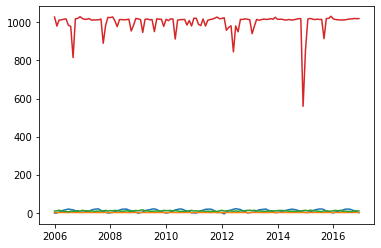

In [8]:
plt.plot(tsmv)

In [9]:
# Define train and testset
dataset = tsmv
testDataset = tsmv[100:]

In [10]:
n_test_entries = 12
train = dataset[:-n_test_entries]
test = dataset[-n_test_entries:]

In [11]:
test_y = test[['Temperature']].values.flatten()
test_X = test.drop('Temperature',axis=1).values
train_y = train[['Temperature']].values.flatten()
train_X = train.drop('Temperature',axis=1).values

In [12]:
# Define scoring methods

from sklearn.metrics import r2_score

def calc_rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0)) * 100

In [13]:
dataset

,Temperature,Humidity,Wind speed,Pressure
Date,,,,
2006-01-01,-2.549821,0.877419,8.490413,1028.117742
2006-02-01,-1.337103,0.882500,9.471975,980.622500
2006-03-01,2.932079,0.829677,13.169281,1011.892903
2006-04-01,10.229815,0.824333,8.794357,1013.625667
2006-05-01,12.796774,0.829032,7.604394,1016.817097
...,...,...,...,...
2016-08-01,18.363978,0.799355,7.098542,1018.076452
2016-09-01,15.087778,0.816000,4.617480,1018.349667
2016-10-01,8.487993,0.851613,10.896584,1020.696129


## VARMAX

In [13]:
# from sklearn.metrics import mean_squared_error,r2_score
# import itertools
# import warnings
# import sys
# from statsmodels.tsa.statespace.varmax import VARMAX


# # Define the p, d and q parameters to take any value between 0 and 2
# a = b = range(0, 6)

# # Generate all different combinations of p, q and q triplets
# ab = list(itertools.product(a, b))
# best_ab = ab
# best_r2 = -2
# warnings.filterwarnings("ignore") # specify to ignore warning messages
# for param in ab:
#     history = [x for x in train]
#     predictions = list()
#     print(param)
#     try:   # some parametercombinations might lead to crash, so catch exceptions and continue
#         # fit model
#         model = VARMAX(train.values, order=param)
#         model_fit = model.fit(disp=False)
#         # make prediction
#         output = model_fit.forecast(steps=n_test_entries)
#         output_y = output[:,0]
# #         yt = output[0]
# #         predictions.append(yt)
# #         obs = test[t]
# #         history.append(yt)
#         r2 = r2_score(test_y,output_y)
        
#         print('R square: ' + str(r2))    
#         if r2 > best_r2:
#             best_r2 = r2
#             best_ab = param
#             best_predictions = output_y
            
#     except Exception as e:
#         print(e)
#         continue
   
# # plot
# print('Best R2 = ' + str(best_r2))
# print(best_ab)
# plt.plot(test,color='blue')
# plt.plot(best_predictions, color='red')
# plt.show()

(0, 0)
Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
(0, 1)
R square: 0.030933900799416603
(0, 2)
R square: 0.09266041590040064
(0, 3)
R square: 0.11412763137772963
(0, 4)
R square: -0.09443827131159721
(0, 5)
R square: 0.1725238050736374
(1, 0)
R square: -0.19196405807176098
(1, 1)
R square: 0.038282751730094655
(1, 2)
R square: -0.11419246924112603
(1, 3)
R square: -0.15603492158477272
(1, 4)
R square: 0.024948351022235915
(1, 5)
Schur decomposition solver error.
(2, 0)
R square: 0.5895596390170881
(2, 1)
R square: 0.5733474968042643
(2, 2)
R square: 0.5752394821341764
(2, 3)
R square: 0.6286491604053654
(2, 4)
R square: 0.5834824595210685
(2, 5)
Schur decomposition solver error.
(3, 0)
R square: 0.7634060070812267
(3, 1)
R square: 0.8424393449346833
(3, 2)
R square: 0.8159441688426954
(3, 3)
R square: 0.8379933164648254
(3, 4)
R square: 0.819701851649197
(3, 5)
Schur decomposition solver error.
(4, 0)
R square: 0.8830079284588568
(4, 1)
R square: 0.9

ValueError: view limit minimum -36814.950000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [12]:
from sklearn.metrics import mean_squared_error,r2_score
import itertools
import warnings
import sys
from statsmodels.tsa.statespace.varmax import VARMAX


# Define the p, d and q parameters to take any value between 0 and 2
a = range(0, 6)
b =  range(1, 6)

# Generate all different combinations of p, q and q triplets
ab = list(itertools.product(a, b))
best_ab = ab
best_r2 = -2
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in ab:
    history = [x for x in train]
    predictions = list()
    print(param)
    # fit model
    model = VARMAX(train.values, order=param)
    model_fit = model.fit(disp=False)
    # make prediction
    output = model_fit.forecast(steps=n_test_entries)
    output_y = output[:,0]
#         yt = output[0]
#         predictions.append(yt)
#         obs = test[t]
#         history.append(yt)
    r2 = r2_score(test_y,output_y)

    print('R square: ' + str(r2))    
    if r2 > best_r2:
        best_r2 = r2
        best_ab = param
        best_predictions = output_y

#     print(e)
#     continue
   
# plot
print('Best R2 = ' + str(best_r2))
print(best_ab)
plt.plot(test,color='blue')
plt.plot(best_predictions, color='red')
plt.show()

C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0, 1)
R square: 0.030933900799416603
(0, 2)
R square: 0.09266041590040064
(0, 3)
R square: 0.11412763137772963
(0, 4)
R square: -0.09443827131159721
(0, 5)
R square: 0.1725238050736374
(1, 1)
R square: 0.038282751730094655
(1, 2)
R square: -0.11419246924112603
(1, 3)
R square: -0.15603492158477272
(1, 4)
R square: 0.024948351022235915
(1, 5)


LinAlgError: Schur decomposition solver error.

In [32]:
%%time

from statsmodels.tsa.statespace.varmax import VARMAX
    
# fit model
model = VARMAX(train.values, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast(steps=n_test_entries)
predictions_y = yhat[:,0]

Wall time: 25.8 s


In [29]:
print()
rmspe_VARMAX = calc_rmspe(test_y, predictions_y)
print('Test RMSPE: %.3f' % rmspe_VARMAX)
r2_VARMAX = r2_score(test_y,predictions_y)
print('R square: ' + str(r2_VARMAX))  


Test RMSPE: 1491.483
R square: 0.038282751730094655


In [11]:
# def test_stationarity(timeseries):
    
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(12).std()

#     #Plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
# test_stationarity(tsuv)

NameError: name 'tsuv' is not defined

In [12]:
# moving_avg = tsuv.rolling(12).mean()
# ts_moving_avg_diff = tsuv - moving_avg
# ts_moving_avg_diff.head(12)

NameError: name 'tsuv' is not defined

In [13]:
# # Lets drop these NaN values and check the plots to test stationarity by 
# # using the function "test_stationarity" we defined earlier
# ts_moving_avg_diff.dropna(inplace=True)
# test_stationarity(ts_moving_avg_diff)

NameError: name 'ts_moving_avg_diff' is not defined

C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


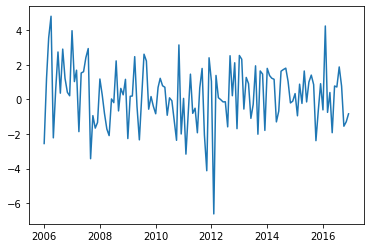

                0
count  132.000000
mean     0.232251
std      1.749970
min     -6.614967
25%     -0.832862
50%      0.224672
75%      1.385530
max      4.799466


In [16]:
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# # fit model
# model = SARIMAX(tsuv, order=(6,1,1))  # MS = month start
# model_fit = model.fit(disp=0)
# # plot residual errors
# residuals = pd.DataFrame(model_fit.resid)
# plt.plot(residuals)
# plt.show()
# print(residuals.describe())

predicted=7.789426, expected=9.654630
predicted=13.848624, expected=14.946774
predicted=17.624575, expected=16.699074
predicted=18.223736, expected=17.908781
predicted=17.369609, expected=19.185484
predicted=14.572527, expected=12.571667
predicted=8.667552, expected=10.231541
predicted=5.100899, expected=6.535370
predicted=1.820435, expected=0.272222
predicted=-0.197526, expected=1.684588
predicted=1.734741, expected=3.153175
predicted=4.709919, expected=6.491935
predicted=9.273721, expected=10.749630
predicted=13.930875, expected=13.037097
predicted=16.530495, expected=16.138889
predicted=16.990500, expected=18.444265
predicted=15.617895, expected=17.463082
predicted=12.766348, expected=14.917963
predicted=9.477940, expected=10.954659
predicted=5.818796, expected=6.095370
predicted=2.411082, expected=2.595161
predicted=0.746894, expected=1.268996
predicted=1.375274, expected=0.704365
predicted=3.717889, expected=4.846416
predicted=8.309645, expected=8.304074
predicted=12.425026, expec

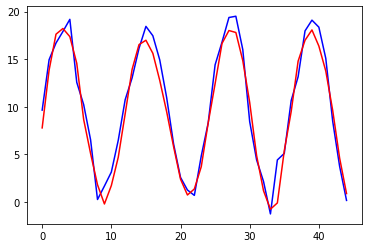

In [17]:
# import math
# from sklearn.metrics import mean_squared_error,r2_score
# X = tsuv.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]  # first 2/3 = training set, remaining 1/3 = test set
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
#     model = ARIMA(history, order=(6,0,1))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yt = output[0]
#     predictions.append(yt)
#     obs = test[t]
#     history.append(obs)
#     print('predicted=%f, expected=%f' % (yt, obs))
# error = mean_squared_error(test, predictions)
# print('Test RMSE: %.3f' % math.sqrt(error))

# rsmeARIMA = math.sqrt(error)
# rsqARIMA =  r2_score(test,predictions)

# r2 = r2_score(test,predictions)
# print('R square: ' + str(r2))       
# # plot
# plt.plot(test,color='blue',label='true')
# plt.plot(predictions, color='red',label='predicted')

# plt.show()

## LSTM

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [24]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.142027,0.793825,0.358361,0.990989,0.186121,0.809512,0.449184,0.890624
2,0.186121,0.809512,0.449184,0.890624,0.341349,0.646414,0.791294,0.956703
3,0.341349,0.646414,0.791294,0.956703,0.606695,0.629914,0.386484,0.960365
4,0.606695,0.629914,0.386484,0.960365,0.700030,0.644422,0.276378,0.967109
5,0.700030,0.644422,0.276378,0.967109,0.817765,0.795618,0.202454,0.969972
...,...,...,...,...,...,...,...,...
127,0.929222,0.606574,0.187907,0.964551,0.902454,0.552789,0.229572,0.969770
128,0.902454,0.552789,0.229572,0.969770,0.783331,0.604183,0.000000,0.970348
129,0.783331,0.604183,0.000000,0.970348,0.543362,0.714144,0.581003,0.975306
130,0.543362,0.714144,0.581003,0.975306,0.371445,0.928386,0.411313,0.972924


In [25]:
values[0]

array([-2.5498209e+00,  8.7741935e-01,  8.4904127e+00,  1.0281178e+03],
      dtype=float32)

In [26]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
# print(reframed.head())

In [27]:
# split into train and test sets
values = reframed.values
n_train_days = 100
# n_test_days = values.shape[0] - 3000

train = values[:n_train_days, :]
test = values[n_train_days:]

In [28]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [29]:
test_X

array([[0.7087678 , 0.6444223 , 0.37037462, 0.9592583 ],
       [0.82154906, 0.39628148, 0.27917463, 0.9637883 ],
       [0.90537274, 0.69721127, 0.29271668, 0.95827603],
       [0.86969686, 0.69920325, 0.2274571 , 0.9612262 ],
       [0.7771561 , 0.8378155 , 0.2748047 , 0.9665215 ],
       [0.6330502 , 0.85159373, 0.3182823 , 0.9734566 ],
       [0.45636624, 0.8398738 , 0.37133896, 0.9730356 ],
       [0.32909846, 0.7599602 , 0.60046506, 0.        ],
       [0.28087902, 0.7141435 , 0.75135994, 0.6198057 ],
       [0.260349  , 0.7499645 , 0.46924233, 0.9678147 ],
       [0.41095418, 0.44023895, 0.82084835, 0.97568774],
       [0.53667486, 0.19249678, 0.6411779 , 0.96925235],
       [0.75863576, 0.5418327 , 0.47340596, 0.96276283],
       [0.8453852 , 0.5136123 , 0.37287837, 0.9675541 ],
       [0.93932176, 0.5129483 , 0.22346848, 0.9641166 ],
       [0.9441242 , 0.618526  , 0.08492404, 0.9652617 ],
       [0.81705797, 0.5866866 , 0.45943135, 0.7509252 ],
       [0.5419742 , 0.89143443,

In [30]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(100, 1, 4) (100,) (31, 1, 4) (31,)


Epoch 1/150
2/2 - 0s - loss: 0.6336 - val_loss: 0.6489
Epoch 2/150
2/2 - 0s - loss: 0.6123 - val_loss: 0.6272
Epoch 3/150
2/2 - 0s - loss: 0.5911 - val_loss: 0.6056
Epoch 4/150
2/2 - 0s - loss: 0.5699 - val_loss: 0.5840
Epoch 5/150
2/2 - 0s - loss: 0.5488 - val_loss: 0.5624
Epoch 6/150
2/2 - 0s - loss: 0.5279 - val_loss: 0.5408
Epoch 7/150
2/2 - 0s - loss: 0.5071 - val_loss: 0.5191
Epoch 8/150
2/2 - 0s - loss: 0.4862 - val_loss: 0.4974
Epoch 9/150
2/2 - 0s - loss: 0.4653 - val_loss: 0.4755
Epoch 10/150
2/2 - 0s - loss: 0.4443 - val_loss: 0.4534
Epoch 11/150
2/2 - 0s - loss: 0.4231 - val_loss: 0.4311
Epoch 12/150
2/2 - 0s - loss: 0.4016 - val_loss: 0.4086
Epoch 13/150
2/2 - 0s - loss: 0.3801 - val_loss: 0.3864
Epoch 14/150
2/2 - 0s - loss: 0.3591 - val_loss: 0.3648
Epoch 15/150
2/2 - 0s - loss: 0.3398 - val_loss: 0.3437
Epoch 16/150
2/2 - 0s - loss: 0.3216 - val_loss: 0.3236
Epoch 17/150
2/2 - 0s - loss: 0.3049 - val_loss: 0.3036
Epoch 18/150
2/2 - 0s - loss: 0.2896 - val_loss: 0.2838
E

Epoch 147/150
2/2 - 0s - loss: 0.1166 - val_loss: 0.0954
Epoch 148/150
2/2 - 0s - loss: 0.1165 - val_loss: 0.0953
Epoch 149/150
2/2 - 0s - loss: 0.1165 - val_loss: 0.0952
Epoch 150/150
2/2 - 0s - loss: 0.1164 - val_loss: 0.0952


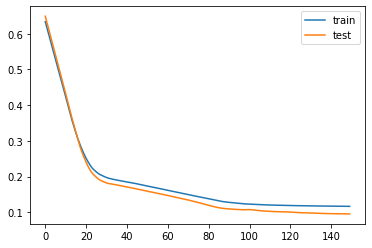

In [31]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [33]:
zeros = np.zeros(dataset.shape[0]-inv_yhat.shape[0]).astype(np.float32)
predictions = np.concatenate((zeros, inv_yhat), axis=None)
dataset['Predictions_open'] = predictions
dataset[['Predictions_open']] = dataset[['Predictions_open']].replace(0,np.NaN)

In [34]:
dataset = dataset.reset_index()

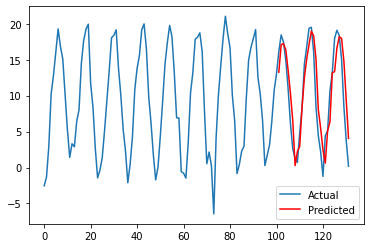

In [35]:
pyplot.plot(dataset[['Temperature']].values, label='Actual')
pyplot.plot(dataset[['Predictions_open']], label='Predicted', color='red')

pyplot.legend()
pyplot.show()

In [36]:
# calculate RMSE
rmspe_LSTM = calc_rmspe(inv_y, inv_yhat)
rsq_LSTM = r2_score(inv_y,inv_yhat)
print('Test RMSPE: %.3f' % rmspe_LSTM)
print('Test root square error: %.3f' % rsq_LSTM)

Test RMSE: 405.196
Test root square error: 0.776


## Polynomial regression

### Evaluation

In [28]:
print('ARIMA RMSE:\t %.3f' % rsmeARIMA)
print('ARIMA r2:\t %.3f' % rsqARIMA)
print()
print('LSTM RMSE:\t %.3f' % rmspe_LSTM)
print('LSTM r2:\t %.3f' % rsq_LSTM)

NameError: name 'rsmeARIMA' is not defined